### Libraries

In [51]:
#Essentials
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from umap import UMAP

#User libraries
from BatchEffectDataLoader import DataPreprocess, DataTransform

### Autoencoder class

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, d_z = 10, input_size = 24, batch_size = 2):
        super().__init__()
        self.d_z = d_z
        self.input_size = input_size
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Linear(128, 64),
            nn.Linear(64, d_z)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_z, 64),
            nn.Linear(64, 128),
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        z = self.encoder(x)
        decoded = self.decoder(z)
        return decoded.view(-1, self.input_size)
    
    def encode(self, x):
        x = x.view(-1, self.input_size)
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

### Autoencoder with batch information class

In [4]:
class BatchAutoencoder(nn.Module):
    def __init__(self, 
                 d_z = 10, 
                 input_size = 24, 
                 batch_size = 2):
        super().__init__()
        self.d_z = d_z
        self.input_size = input_size
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size + batch_size, 128),
            nn.Linear(128, 64),
            nn.Linear(64, d_z)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_z, 64),
            nn.Linear(64, 128),
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size + self.batch_size)
        z = self.encoder(x)
        decoded = self.decoder(z)
        return decoded.view(-1, self.input_size)
    
    def encode(self, x):
        x = x.view(-1, self.input_size + self.batch_size)
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def loss(self, out, x):
        x = x.view(-1, self.input_size + self.batch_size)
        x = x[:, :-self.batch_size]
        return nn.MSELoss()(out, x)
        

### Batch discriminator class (FFNN)

In [5]:
class BatchDiscriminator(nn.Module):
    def __init__(self,
                 input_size = 24,
                 hl1_size = 128,
                 hl2_size = 64,
                 batch_size = 2,
                 tissue_size = 2):
        super().__init__()
        self.input_size = input_size
        self.hl1_size = hl1_size
        self.hl2_size = hl2_size
        self.batch_size = batch_size
        self.tissue_size = tissue_size
        self.ffnn = nn.Sequential(
            nn.Linear(input_size + tissue_size, hl1_size),
            nn.ReLU(),
            nn.Linear(hl1_size, hl2_size),
            nn.ReLU(),
            nn.Linear(hl2_size, batch_size)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size + self.tissue_size)
        y = self.ffnn(x)
        return y
    
    def loss(self, out, y):
        return nn.CrossEntropyLoss()(out, y)

### Tissue classifier class (FFNN)

In [6]:
class TissueClassifier(nn.Module):
    def __init__(self,
                 input_size,
                 hl1_size = 128,
                 hl2_size = 64,
                 tissue_size = 2):
        super().__init__()
        self.input_size = input_size
        self.hl1_size = hl1_size
        self.hl2_size = hl2_size
        self.tissue_size = tissue_size
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hl1_size),
            nn.ReLU(),
            nn.Linear(hl1_size, hl2_size),
            nn.ReLU(),
            nn.Linear(hl2_size, tissue_size)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        y = self.ffnn(x)
        return y
    
    def loss(self, out, y):
        return nn.CrossEntropyLoss()(out, y)

### Train autoencoder model function

In [7]:
def train_ae_model(
        model,
        train_loader,
        criterion,
        optimizer,
        num_epochs,
        device,
        val_loader = None,
        test_loader = None,
        model_name = "model",
        save_model = False
):
    train_losses = []
    test_losses = []
    val_losses = []
    lowest_val_loss = float('inf')
    best_epoch = -1
    best_model_state = None

    for epoch in range(num_epochs):
        #Training
        model.train()
        train_loss = 0.0
        for x in train_loader:
            #Forward pass
            x = x.to(device)
            out = model(x)

            #Backpropagation
            loss = criterion(out, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Save loss values
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        #Validation
        model.eval()
        if isinstance(val_loader, DataLoader):
            val_loss = 0.0
            with torch.no_grad():
                for x in val_loader:
                    #Forward pass
                    x = x.to(device)
                    out = model(x)

                    #Save loss values
                    loss = criterion(out, x)
                    val_loss += loss.item()
                
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_epoch = epoch
                best_model_state = model.state_dict()
            print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        else:
            print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}")

    #Testing
    if isinstance(test_loader, DataLoader):
        test_loss = 0.0
        with torch.no_grad():
            for x in test_loader:
                #Forward pass
                x = x.to(device)
                out = model(x)

                #Save loss values
                loss = criterion(out, x)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print(f"Test Loss: {test_loss:.4f}")

    if save_model == True:
        script_path = os.getcwd()
        dest = os.path.join(script_path, f'model_weights/{model_name}_best.pth')
        if not os.path.exists(os.path.dirname(dest)):
            os.makedirs(os.path.dirname(dest), exist_ok=True)
        torch.save(best_model_state, dest)

    return train_losses, val_losses, test_losses, best_epoch

### Train classification model function

In [97]:
def train_class_model(
        model,
        train_loader,
        criterion,
        optimizer,
        num_epochs,
        device,
        val_loader = None,
        test_loader = None,
        model_name = "model",
        save_model = False
):
    train_losses = []
    test_losses = []
    val_losses = []
    lowest_val_loss = float('inf')
    best_epoch = -1
    best_model_state = None

    for epoch in range(num_epochs):
        #Training
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            #Forward pass
            x = x.to(device)
            out = model(x)

            #Backpropagation
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Save loss values
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        #Validation
        model.eval()
        if isinstance(val_loader, DataLoader):
            val_loss = 0.0
            with torch.no_grad():
                for x,y in val_loader:
                    #Forward pass
                    x = x.to(device)
                    out = model(x)

                    #Save loss values
                    loss = criterion(out, y)
                    val_loss += loss.item()
                
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_epoch = epoch
                best_model_state = model.state_dict()
            print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        else:
            print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}")

    #Testing
    if isinstance(test_loader, DataLoader):
        test_loss = 0.0
        with torch.no_grad():
            for x,y in test_loader:
                #Forward pass
                x = x.to(device)
                out = model(x)

                #Save loss values
                loss = criterion(out, y)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print(f"Test Loss: {test_loss:.4f}")

    if save_model == True:
        script_path = os.getcwd()
        dest = os.path.join(script_path, f'model_weights/{model_name}_best.pth')
        if not os.path.exists(os.path.dirname(dest)):
            os.makedirs(os.path.dirname(dest), exist_ok=True)
        torch.save(best_model_state, dest)

    return train_losses, val_losses, test_losses, best_epoch

### Train ABC model

In [63]:
def train_abc_model(
        ae_model,
        batch_model,
        out_class_model,
        latent_class_model,
        train_loader, # tensor: ([otus and batch ohe],[tissue classes (int)])
        tissue_ohe,
        num_epochs,
        device,
        w_recon = 1.0,
        w_adver = 1.0,
        w_latent = 1.0,
        w_output = 1.0,
        w_disc = 1.0,
        val_loader = None,
        test_loader = None,
        model_name = "model",
        save_model = False
):
    train_dis_losses = []
    train_adv_losses = []
    train_tri_losses = []
    test_losses = []
    val_losses = []
    lowest_val_loss = float('inf')
    best_epoch = -1
    best_model_state = None

    #Optimizer for discriminator only
    step_1_optimizer = torch.optim.Adam(batch_model.parameters(), lr = 1e-3, weight_decay=1e-5)
    #Optimizer for adversarial training (autoencoder only)
    step_2_optimizer = torch.optim.Adam(ae_model.parameters(), lr = 1e-3, weight_decay=1e-5)
    #Optimizer for biological conservation (autoencoder and classifiers)
    step_3_1_optimizer = torch.optim.Adam(ae_model.parameters(), lr = 1e-3, weight_decay=1e-5)
    step_3_2_optimizer = torch.optim.Adam(latent_class_model.parameters(), lr = 1e-3, weight_decay=1e-5)
    step_3_3_optimizer = torch.optim.Adam(out_class_model.parameters(), lr = 1e-3, weight_decay=1e-5)

    #Loss function for discriminator only
    step_1_criterion = nn.CrossEntropyLoss()
    #Adversarial loss function of autoencoder
    step_2_criterion = nn.KLDivLoss()
    #Biological conservation loss functions
    step_3_1_criterion = nn.MSELoss()
    step_3_2_criterion = nn.CrossEntropyLoss()
    step_3_3_criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        #Training
        ae_model.train()
        batch_model.train()
        out_class_model.train()
        latent_class_model.train()
        train_dis_loss = 0.0
        train_adv_loss = 0.0
        train_tri_loss = 0.0
        for x, y in train_loader:
            #Forward pass to Autoencoder
            x = x.to(device)
            z = ae_model.encode(x)
            out_ae = ae_model.decode(z)

            #Forward pass to discriminator
            input_disc = torch.concat((out_ae, tissue_ohe), 1) # reconstructed otus + tissue ohe
            out_batch_class = batch_model(input_disc)

            #1st Backpropagation: Discriminator
            step_1_loss = w_disc * step_1_criterion(out_batch_class, x[:, -2:])
            step_1_optimizer.zero_grad()
            step_1_loss.backward(retain_graph=True)
            step_1_optimizer.step()
            out_batch_class = out_batch_class.detach()
            out_batch_class = batch_model(input_disc)
            out_ae = out_ae.detach()
            z = z.detach()
            z = ae_model.encode(x)
            out_ae = ae_model.decode(z)

            #2nd Backpropagation: Adversarial AE
            target_dist = torch.full_like(out_batch_class, 0.5)
            out_batch_prob = torch.log_softmax(out_batch_class, dim=1)
            step_2_loss = w_adver * step_2_criterion(out_batch_prob, target_dist)
            step_2_optimizer.zero_grad()
            step_2_loss.backward(retain_graph=True)
            step_2_optimizer.step()
            out_batch_class = out_batch_class.detach()
            out_batch_class = batch_model(input_disc)
            out_ae = out_ae.detach()
            z = z.detach()
            z = ae_model.encode(x)
            out_ae = ae_model.decode(z)

            #Forward pass to classificators
            out_out_class = out_class_model(out_ae)     #this classifies using AE output
            out_latent_class = latent_class_model(z)    #this classifies using AE latent space

            #3rd Backpropagation: Triple loss function
            step_3_1_loss = step_3_1_criterion(out_ae, x[:,:-2])
            step_3_2_loss = step_3_2_criterion(out_latent_class, y)
            step_3_3_loss = step_3_3_criterion(out_out_class, y)
            step_3_loss = w_recon * step_3_1_loss + w_latent * step_3_2_loss + w_output * step_3_3_loss
            step_3_1_optimizer.zero_grad()
            step_3_2_optimizer.zero_grad()
            step_3_3_optimizer.zero_grad()
            step_3_loss.backward()
            step_3_1_optimizer.step()
            step_3_2_optimizer.step()
            step_3_3_optimizer.step()

            #Save loss values
            train_dis_loss += step_1_loss.item()
            train_adv_loss += step_2_loss.item()
            train_tri_loss += step_3_loss.item()
        
        train_dis_loss /= len(train_loader)
        train_adv_loss /= len(train_loader)
        train_tri_loss /= len(train_loader)
        
        train_dis_losses.append(train_dis_loss)
        train_adv_losses.append(train_adv_loss)
        train_tri_losses.append(train_tri_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} | Dis. Train Loss: {train_dis_loss:.4f} | Adv. Train Loss: {train_dis_loss:.4f} | Tri. Train Loss: {train_dis_loss:.4f}")

        #Validation
    #     model.eval()
    #     if isinstance(val_loader, DataLoader):
    #         val_loss = 0.0
    #         with torch.no_grad():
    #             for x in val_loader:
    #                 #Forward pass
    #                 x = x.to(device)
    #                 out = model(x)

    #                 #Save loss values
    #                 loss = criterion(out, x)
    #                 val_loss += loss.item()
                
    #         val_loss /= len(val_loader)
    #         val_losses.append(val_loss)

    #         if val_loss < lowest_val_loss:
    #             lowest_val_loss = val_loss
    #             best_epoch = epoch
    #             best_model_state = model.state_dict()
    #         print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
    #     else:
    #         print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}")

    # #Testing
    # if isinstance(test_loader, DataLoader):
    #     test_loss = 0.0
    #     with torch.no_grad():
    #         for x in test_loader:
    #             #Forward pass
    #             x = x.to(device)
    #             out = model(x)

    #             #Save loss values
    #             loss = criterion(out, x)
    #             test_loss += loss.item()
        
    #     test_loss /= len(test_loader)
    #     test_losses.append(test_loss)
    #     print(f"Test Loss: {test_loss:.4f}")

    # if save_model == True:
    #     script_path = os.getcwd()
    #     dest = os.path.join(script_path, f'model_weights/{model_name}_best.pth')
    #     if not os.path.exists(os.path.dirname(dest)):
    #         os.makedirs(os.path.dirname(dest), exist_ok=True)
    #     torch.save(best_model_state, dest)

    return train_dis_losses, train_adv_losses, train_tri_losses

### Dataloader

In [9]:
#Function to One-Hot encoding
def one_hot_encoding(labels):
    # Dictionary of batch labels
    alphabet = labels.unique()
    label_to_int = {label: i for i, label in enumerate(alphabet)}

    # Initialize the one-hot encoded matrix
    one_hot = np.zeros((len(labels), len(alphabet)), dtype=int)

    # Fill the matrix
    for i, label in enumerate(labels):
        if label in label_to_int:
            one_hot[i, label_to_int[label]] = 1

    return torch.tensor(one_hot), alphabet.tolist()

#Function for classes to int
def class_to_int(labels):
    # Dictionary of batch labels
    alphabet = labels.unique()
    label_to_int = {label: i for i, label in enumerate(alphabet)}

    # Initialize the empty array
    classes = np.zeros(len(labels), dtype=int)

    # Fill the matrix
    for i, label in enumerate(labels):
        classes[i] = label_to_int[label]
    
    return torch.tensor(classes)

In [14]:
#Load and preprocess data
path = "data/dataset_sponge.csv"
data = DataTransform(DataPreprocess(path))

#Convert data to tensor (structure: tensor([otus], [batch]))
otu_data = data.select_dtypes(include = "number")
otu_tensor = torch.tensor(otu_data.values, dtype = torch.float32)

#Extract labels and convert to one hot encoding matrix
data_batch = data["batch"]
data_tissue = data["tissue"]
ohe_batch, labels_batch = one_hot_encoding(data_batch)
ohe_tissue, labels_tissue = one_hot_encoding(data_tissue)

# dataloader = DataLoader(TensorDataset(otu_tensor), batch_size = 32) #this should be the correct way to define it
batch_size = 32

otu_dataloader = DataLoader(otu_tensor, batch_size = batch_size)
batch_dataloader = DataLoader(ohe_batch, batch_size = batch_size)
tissue_dataloader = DataLoader(ohe_tissue, batch_size = batch_size)

#Defining DataLoader for otus + batch information
otu_batch_tensor = torch.concat((otu_tensor, ohe_batch), 1)
otu_batch_dataloader = DataLoader(otu_batch_tensor, batch_size = batch_size)

#Defining DataLoader for otus + tissue information, also including batch as label for discriminator training
otu_tissue_tensor = torch.concat((otu_tensor, ohe_tissue), 1)
otu_tissue_dataloader = DataLoader(TensorDataset(otu_tissue_tensor, class_to_int(data_batch)), batch_size = batch_size)

#Defining DataLoader for otus including tissue as label for classifier training
otu_tissue_class_dataloader = DataLoader(TensorDataset(otu_tensor, class_to_int(data_tissue)), batch_size = batch_size)

#Defining DataLoader for otus including + batch information, also including tissue as label for discriminator training
abc_dataloader = DataLoader(TensorDataset(otu_batch_tensor, class_to_int(data_tissue)), batch_size = batch_size)

### Training loop for simple autoencoder

In [93]:
#Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=20
print(f"Using {device}")

#Defining autoencoder and optimizer
d_z = 2
autoencoder = Autoencoder(d_z=d_z).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

#Training loop
train_losses, val_losses, test_losses, best_epoch = train_ae_model(
    model=autoencoder,
    train_loader=otu_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    model_name="autoencoder" 
)

Using cpu
Epoch 1/20 | Train Loss: 77.8566
Epoch 2/20 | Train Loss: 75.7957
Epoch 3/20 | Train Loss: 72.8945
Epoch 4/20 | Train Loss: 69.0315
Epoch 5/20 | Train Loss: 64.3128
Epoch 6/20 | Train Loss: 59.0542
Epoch 7/20 | Train Loss: 53.8466
Epoch 8/20 | Train Loss: 49.6417
Epoch 9/20 | Train Loss: 47.5527
Epoch 10/20 | Train Loss: 47.5754
Epoch 11/20 | Train Loss: 47.5758
Epoch 12/20 | Train Loss: 46.1851
Epoch 13/20 | Train Loss: 43.9197
Epoch 14/20 | Train Loss: 41.7444
Epoch 15/20 | Train Loss: 40.2266
Epoch 16/20 | Train Loss: 39.4272
Epoch 17/20 | Train Loss: 39.1297
Epoch 18/20 | Train Loss: 39.0876
Epoch 19/20 | Train Loss: 39.1297
Epoch 20/20 | Train Loss: 39.1401


### Training loop for batch-informed autoencoder

In [94]:
#Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=20
print(f"Using {device}")

#Defining autoencoder and optimizer
d_z = 2
batch_autoencoder = BatchAutoencoder(d_z=d_z).to(device)
criterion = batch_autoencoder.loss
optimizer = torch.optim.Adam(batch_autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

#Training loop
train_losses, val_losses, test_losses, best_epoch = train_ae_model(
    model=batch_autoencoder,
    train_loader=otu_batch_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    model_name="autoencoder" 
)

Using cpu
Epoch 1/20 | Train Loss: 78.9253
Epoch 2/20 | Train Loss: 77.2421
Epoch 3/20 | Train Loss: 76.0406
Epoch 4/20 | Train Loss: 74.1193
Epoch 5/20 | Train Loss: 71.1850
Epoch 6/20 | Train Loss: 67.3267
Epoch 7/20 | Train Loss: 62.8728
Epoch 8/20 | Train Loss: 58.4049
Epoch 9/20 | Train Loss: 54.7456
Epoch 10/20 | Train Loss: 52.7207
Epoch 11/20 | Train Loss: 52.1607
Epoch 12/20 | Train Loss: 51.4300
Epoch 13/20 | Train Loss: 49.7312
Epoch 14/20 | Train Loss: 47.6621
Epoch 15/20 | Train Loss: 45.9955
Epoch 16/20 | Train Loss: 45.0400
Epoch 17/20 | Train Loss: 44.6364
Epoch 18/20 | Train Loss: 44.4264
Epoch 19/20 | Train Loss: 44.1030
Epoch 20/20 | Train Loss: 43.5188


### Training loop for simple batch discriminator with tissue information

In [133]:
#Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=20
print(f"Using {device}")

#Defining autoencoder and optimizer
batch_discriminator = BatchDiscriminator().to(device)
criterion = batch_discriminator.loss
optimizer = torch.optim.Adam(batch_discriminator.parameters(), lr=1e-3, weight_decay=1e-5)

#Training loop
train_losses, val_losses, test_losses, best_epoch = train_class_model(
    model=batch_discriminator,
    train_loader=otu_tissue_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    model_name="discriminator" 
)

Using cpu
Epoch 1/20 | Train Loss: 0.9107
Epoch 2/20 | Train Loss: 0.6592
Epoch 3/20 | Train Loss: 0.4906
Epoch 4/20 | Train Loss: 0.3755
Epoch 5/20 | Train Loss: 0.2903
Epoch 6/20 | Train Loss: 0.2231
Epoch 7/20 | Train Loss: 0.1692
Epoch 8/20 | Train Loss: 0.1272
Epoch 9/20 | Train Loss: 0.0966
Epoch 10/20 | Train Loss: 0.0750
Epoch 11/20 | Train Loss: 0.0593
Epoch 12/20 | Train Loss: 0.0469
Epoch 13/20 | Train Loss: 0.0368
Epoch 14/20 | Train Loss: 0.0285
Epoch 15/20 | Train Loss: 0.0219
Epoch 16/20 | Train Loss: 0.0168
Epoch 17/20 | Train Loss: 0.0130
Epoch 18/20 | Train Loss: 0.0102
Epoch 19/20 | Train Loss: 0.0082
Epoch 20/20 | Train Loss: 0.0066


### Training loop for simple tissue classifier 

In [147]:
#Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=200
print(f"Using {device}")

#Defining autoencoder and optimizer
tissue_classifier = TissueClassifier(input_size=24).to(device)
criterion = tissue_classifier.loss
optimizer = torch.optim.Adam(tissue_classifier.parameters(), lr=1e-3, weight_decay=1e-5)

#Training loop
train_losses, val_losses, test_losses, best_epoch = train_class_model(
    model=tissue_classifier,
    train_loader=otu_tissue_class_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    model_name="classifier" 
)

Using cpu
Epoch 1/200 | Train Loss: 0.6848
Epoch 2/200 | Train Loss: 0.6069
Epoch 3/200 | Train Loss: 0.5405
Epoch 4/200 | Train Loss: 0.4850
Epoch 5/200 | Train Loss: 0.4401
Epoch 6/200 | Train Loss: 0.4060
Epoch 7/200 | Train Loss: 0.3812
Epoch 8/200 | Train Loss: 0.3629
Epoch 9/200 | Train Loss: 0.3492
Epoch 10/200 | Train Loss: 0.3392
Epoch 11/200 | Train Loss: 0.3319
Epoch 12/200 | Train Loss: 0.3267
Epoch 13/200 | Train Loss: 0.3230
Epoch 14/200 | Train Loss: 0.3205
Epoch 15/200 | Train Loss: 0.3186
Epoch 16/200 | Train Loss: 0.3173
Epoch 17/200 | Train Loss: 0.3163
Epoch 18/200 | Train Loss: 0.3156
Epoch 19/200 | Train Loss: 0.3151
Epoch 20/200 | Train Loss: 0.3147
Epoch 21/200 | Train Loss: 0.3144
Epoch 22/200 | Train Loss: 0.3142
Epoch 23/200 | Train Loss: 0.3140
Epoch 24/200 | Train Loss: 0.3139
Epoch 25/200 | Train Loss: 0.3138
Epoch 26/200 | Train Loss: 0.3137
Epoch 27/200 | Train Loss: 0.3136
Epoch 28/200 | Train Loss: 0.3136
Epoch 29/200 | Train Loss: 0.3135
Epoch 30/200 

### Training loop for ABC model

In [66]:
#Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=1000
print(f"Using {device}")

#Defining autoencoder and optimizer
d_z = 10
batch_autoencoder = BatchAutoencoder(d_z=d_z).to(device)
batch_discriminator = BatchDiscriminator().to(device)
latent_classifier = TissueClassifier(input_size=d_z)
output_classifier = TissueClassifier(input_size=24)


#Training loop
train_dis_losses, train_adv_losses, train_tri_losses = train_abc_model(
    ae_model=batch_autoencoder,
    batch_model=batch_discriminator,
    out_class_model=output_classifier,
    latent_class_model=latent_classifier,
    train_loader=abc_dataloader,
    tissue_ohe=ohe_tissue,
    num_epochs=num_epochs,
    w_recon=0.3,
    w_adver=1.0,
    w_disc=1.0,
    w_latent=1.0,
    w_output=1.0,
    device=device,
    model_name="ABC" 
)

Using cpu
Epoch 1/1000 | Dis. Train Loss: 0.6983 | Adv. Train Loss: 0.6983 | Tri. Train Loss: 0.6983
Epoch 2/1000 | Dis. Train Loss: 0.6891 | Adv. Train Loss: 0.6891 | Tri. Train Loss: 0.6891
Epoch 3/1000 | Dis. Train Loss: 0.6797 | Adv. Train Loss: 0.6797 | Tri. Train Loss: 0.6797
Epoch 4/1000 | Dis. Train Loss: 0.6777 | Adv. Train Loss: 0.6777 | Tri. Train Loss: 0.6777


/home/edircoli/miniforge3/envs/BECA/lib/python3.12/site-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 5/1000 | Dis. Train Loss: 0.6783 | Adv. Train Loss: 0.6783 | Tri. Train Loss: 0.6783
Epoch 6/1000 | Dis. Train Loss: 0.6808 | Adv. Train Loss: 0.6808 | Tri. Train Loss: 0.6808
Epoch 7/1000 | Dis. Train Loss: 0.6791 | Adv. Train Loss: 0.6791 | Tri. Train Loss: 0.6791
Epoch 8/1000 | Dis. Train Loss: 0.6779 | Adv. Train Loss: 0.6779 | Tri. Train Loss: 0.6779
Epoch 9/1000 | Dis. Train Loss: 0.6751 | Adv. Train Loss: 0.6751 | Tri. Train Loss: 0.6751
Epoch 10/1000 | Dis. Train Loss: 0.6703 | Adv. Train Loss: 0.6703 | Tri. Train Loss: 0.6703
Epoch 11/1000 | Dis. Train Loss: 0.6646 | Adv. Train Loss: 0.6646 | Tri. Train Loss: 0.6646
Epoch 12/1000 | Dis. Train Loss: 0.6610 | Adv. Train Loss: 0.6610 | Tri. Train Loss: 0.6610
Epoch 13/1000 | Dis. Train Loss: 0.6553 | Adv. Train Loss: 0.6553 | Tri. Train Loss: 0.6553
Epoch 14/1000 | Dis. Train Loss: 0.6433 | Adv. Train Loss: 0.6433 | Tri. Train Loss: 0.6433
Epoch 15/1000 | Dis. Train Loss: 0.6385 | Adv. Train Loss: 0.6385 | Tri. Train Loss: 

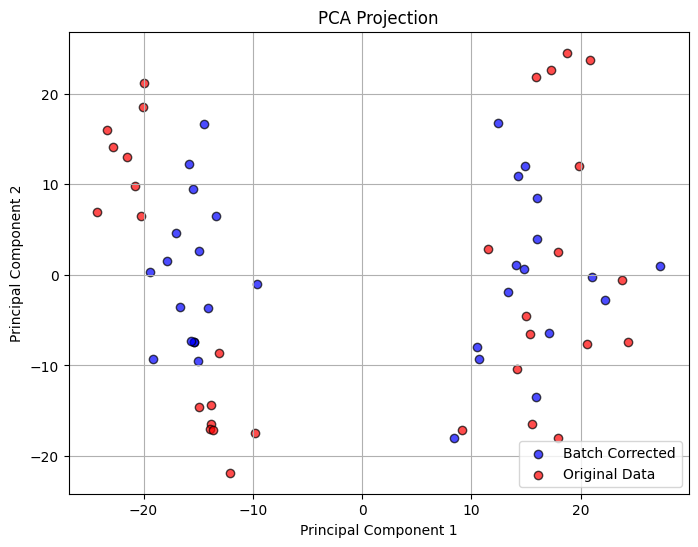

In [67]:
batch_corrected = []
for x, _ in abc_dataloader:

    batch_corrected.append(batch_autoencoder(x).tolist())

batch_corrected = np.array(batch_corrected)  # Convert list to NumPy array
batch_corrected = batch_corrected.reshape(-1, batch_corrected.shape[-1])

original_data = np.array(otu_data.values)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
batch_corrected_2d = pca.fit_transform(batch_corrected)
original_2d = pca.fit_transform(original_data)

plt.figure(figsize=(8, 6))
# Plot batch_corrected_2d
plt.scatter(batch_corrected_2d[:, 0], batch_corrected_2d[:, 1], alpha=0.7, label='Batch Corrected', color='blue', edgecolor='k')
# Plot original_2d
plt.scatter(original_2d[:, 0], original_2d[:, 1], alpha=0.7, label='Original Data', color='red', edgecolor='k')
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()